In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
import newcmaps

import numpy as np
import healpy as hp
import scipy
from scipy import special as ss
from scipy import linalg as sl
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import math,glob,sys,json
import h5py as h5
from collections import OrderedDict
import NX01_bayesutils as bu
import NX01_utils as utils
import NX01_psr

import AnisCoefficients_pix as pixAnis
import plot
import corner

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
    
yr = 365.25*86400.0

/Users/staylor/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# IPTA MDC injection

## Injected map

In [2]:
clm_inj = np.load('nanogravTests_pointAnis.npy')

In [3]:
clm_inj

array([ 3.5449077 , -0.58004952,  0.5000429 ,  0.38757574, -0.58507975,
       -0.75636711,  0.00869584,  0.50537718, -0.24235522, -0.10852881,
       -0.90302081, -0.38019683, -0.49805607,  0.25403584, -0.37405437,
       -0.54562877,  0.33893872, -0.18974301, -0.69957401,  0.28682588,
       -0.58943123, -0.19167782, -0.28981041, -0.95390645, -0.33894172])

[ 0.38536383  0.41511958  0.3729763  ...,  0.66330189  0.62887411
  0.60806515] [ 3.5449077  -0.58004952  0.5000429   0.38757574 -0.58507975 -0.75636711
  0.00869584  0.50537718 -0.24235522 -0.10852881 -0.90302081 -0.38019683
 -0.49805607  0.25403584 -0.37405437 -0.54562877  0.33893872 -0.18974301
 -0.69957401  0.28682588 -0.58943123 -0.19167782 -0.28981041 -0.95390645
 -0.33894172]


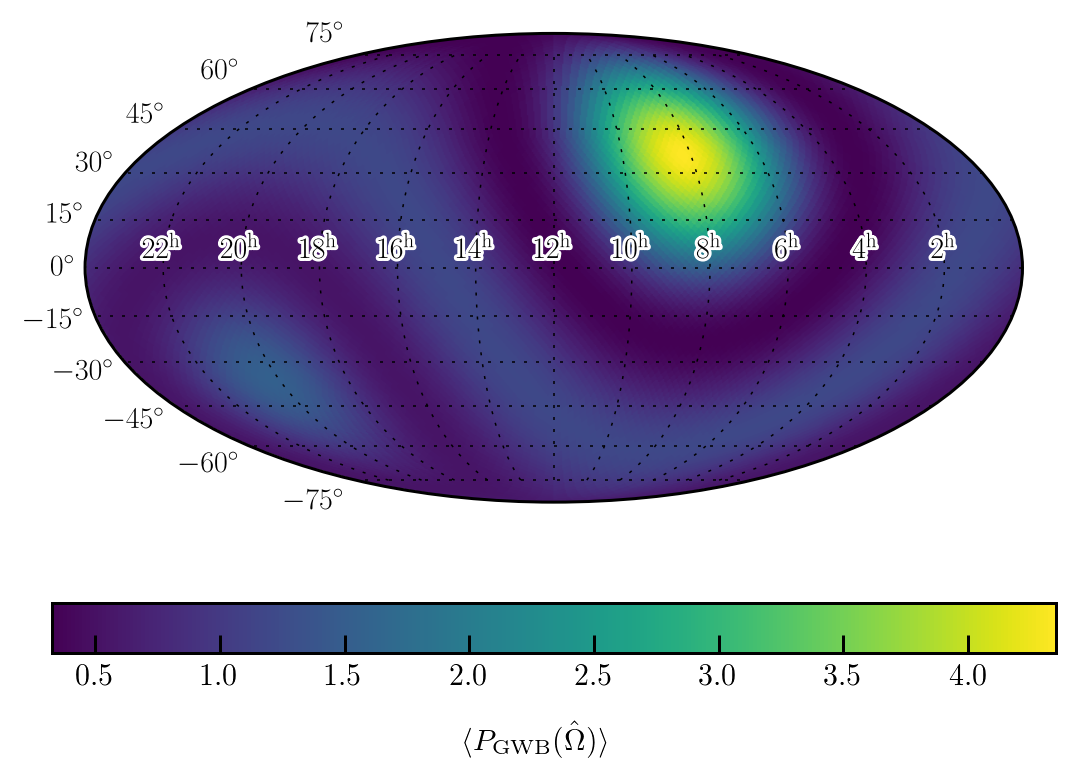

In [5]:
map_inj = bu.makeSkyMap(clm_inj[1:],lmax=4,nside=32,cmap=newcmaps.viridis)
plt.title('Injected')
#plt.savefig('nanoAnisTests_pointInj.png',bbox_inches='tight',dpi=400)

## Spherical harmonic analysis: produce posterior averaged skymap

In [ ]:
dirnames = sorted(glob.glob('chains_iptamdc_mockanishotspot_dataset*'))

In [ ]:
dirnames

In [ ]:
clm_chain = []
for ii,name in enumerate(dirnames):
    try:
        clm_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.0.txt'))
    except:
        clm_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.txt'))

In [ ]:
LMAX = 4

In [ ]:
#### Making skymaps out of all clm samples ####

hchain = np.zeros((len(clm_chain[0]),hp.nside2npix(nside=32)))
for ii in range(len(clm_chain[0])):
    sample = np.append(2.0*np.sqrt(np.pi), clm_chain[0][ii,-4-(LMAX+1)**2+1:-4])
    hchain[ii,:] = pixAnis.mapFromClm_fast(sample,nside=32)

    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(clm_chain[0]))
    sys.stdout.flush()

In [ ]:
h_mean = np.mean(hchain,axis=0)
h_std = np.std(hchain,axis=0)

In [ ]:
ind_max = np.argmax(clm_chain[0][:,-4])

In [ ]:
ind_max

In [ ]:
hMAP = pixAnis.mapFromClm_fast(np.append(2.0*np.sqrt(np.pi), clm_chain[0][ind_max,-4-(LMAX+1)**2+1:-4]),nside=32)

In [ ]:
h_conf = np.zeros_like(h_std)
for ii in range(len(h_conf)):
    low, up = bu.confinterval(hchain[:,ii],sigma=0.68,onesided=False)
    h_conf[ii] = up - low
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(h_conf))
    sys.stdout.flush()

In [ ]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap((hMAP - 1.0)/h_conf, cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.suptitle('Anisotropic significance', y=0.1)

In [ ]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(h_mean, cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.suptitle(r'$\langle P_{\mathrm{GWB}}(\hat\Omega)\rangle$', y=0.1)

In [ ]:
fig = plt.figure()

mycolor = matplotlib.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(321, projection = 'astro mollweide')   
bu.makeSkyMap(clm_inj[1:], lmax=LMAX, nside=32, axis=ax1, 
              cmap=matplotlib.cm.get_cmap('Blues'))

ax2 = fig.add_subplot(322, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[0][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax2, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax3 = fig.add_subplot(323, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[1][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax3, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax4 = fig.add_subplot(324, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[2][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax4, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax5 = fig.add_subplot(325, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[3][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax5, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax6 = fig.add_subplot(326, projection = 'astro mollweide')   
bu.makeSkyMap(clm_chain[4][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax6, 
              cmap=matplotlib.cm.get_cmap('Reds'))


plt.tight_layout()
#plt.savefig('iptamdc_hotspotrecovery_manyreals.png',bbox_inches='tight',dpi=400)

In [ ]:
dipole_chain = np.loadtxt('./chains_iptamdc_mockanisdipole_dataset0/pta_gwbloguniform_Lmax1_noPhysPrior_gamVary_redFix_nmodes20/chain_1.txt')

In [ ]:
dipole_chain.shape

In [ ]:
bu.makeSkyMap(dipole_chain[5000:,-4-(1+1)**2+1:-4],
              lmax=1, nside=32, 
              cmap=newcmaps.magma)

In [ ]:
dirnames = sorted(glob.glob('chains_iptamdc_nanotype_mockanishotspot*'))

In [ ]:
dirnames

In [ ]:
nano_chain = []
for ii,name in enumerate(dirnames):
    #try:
    #    nano_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.0.txt'))
    #except:
    nano_chain.append(np.loadtxt(dirnames[ii]+'/pta_gwbloguniform_Lmax4_gamVary_redFix_nmodes20/chain_1.txt'))

In [ ]:
LMAX = 4

In [ ]:
fig = plt.figure()

mycolor = matplotlib.cm.get_cmap('cubehelix')

ax1 = fig.add_subplot(321, projection = 'astro mollweide')   
bu.makeSkyMap(clm_inj[1:], lmax=LMAX, nside=32, axis=ax1, 
              cmap=matplotlib.cm.get_cmap('Blues'))

ax2 = fig.add_subplot(322, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[0][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax2, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax3 = fig.add_subplot(323, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[1][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax3, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax4 = fig.add_subplot(324, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[2][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax4, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax5 = fig.add_subplot(325, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[3][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax5, 
              cmap=matplotlib.cm.get_cmap('Reds'))

ax6 = fig.add_subplot(326, projection = 'astro mollweide')   
bu.makeSkyMap(nano_chain[4][5000:,-4-(LMAX+1)**2+1:-4],
              lmax=LMAX, nside=32, axis=ax6, 
              cmap=matplotlib.cm.get_cmap('Reds'))


plt.tight_layout()
#plt.savefig('iptamdc_hotspotrecovery_manyreals.png',bbox_inches='tight',dpi=400)

In [ ]:
bu.makeSkyMap(nano_chain[1000:,-4-(4+1)**2+1:-4],
              lmax=4, nside=32, 
              cmap=newcmaps.magma)

In [ ]:
nano_priorchain = np.loadtxt('./chains_nano9yr_anisConstLike/pta_constLike_gwbloguniform_Lmax5_gamVary_redloguniformpowerlaw_nmodes15/chain_1.0.txt',
                            usecols=np.arange(38,73))

In [ ]:
bu.makeSkyMap(nano_priorchain[50000:],
              lmax=5, nside=32, 
              cmap=newcmaps.viridis)
plt.title('Constant likelihood (with phys. prior)')
plt.savefig('nano9yr_lmax5physprior_constLike.png',bbox_inches='tight',dpi=400)

In [ ]:
hchain_constLike = []
for ii in range(len(nano_priorchain[50000:])):
    sample = np.append(2.0*np.sqrt(np.pi), nano_priorchain[50000+ii,:])
    hchain_constLike.append(pixAnis.mapFromClm_fast(sample,nside=32))
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(nano_priorchain[50000:]))
    sys.stdout.flush()

In [ ]:
hchain_constLike = np.array(hchain_constLike)

In [ ]:
hmean_constLike = np.mean(hchain_constLike,axis=0)
hstd_constLike = np.std(hchain_constLike,axis=0)

In [ ]:
#h_mean = np.mean(hchain,axis=0)
clmean = np.append(2.0*np.sqrt(np.pi), np.mean(nano_priorchain[50000:,:],axis=0))
h_mean = pixAnis.mapFromClm_fast(clmean,nside=32)

In [ ]:
#hconf_constLike = np.zeros_like(h_mean)
hconf_95upper = np.zeros(12288)
for ii in range(len(hconf_95upper)):
    #low, up = bu.confinterval(hchain_constLike[:,ii],sigma=0.68,onesided=False)
    #hconf_constLike[ii] = up - low
    low, up = bu.confinterval(hchain_constLike[:,ii],sigma=0.95,onesided=True)
    hconf_95upper[ii] = up
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(hconf_95upper))
    sys.stdout.flush()

In [ ]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(hconf_95upper,cmap=newcmaps.viridis)
#plot.healpix_heatmap((hmean_constLike-1.0)/hstd_constLike,cmap=newcmaps.viridis)
plt.colorbar(orientation='horizontal')
plt.title('Constant likelihood (with phys. prior)')
plt.suptitle(r'$P(\hat\Omega)_{95}$', y=0.1)
plt.savefig('nano9yr_lmax5physprior_constLike_95upper.png',bbox_inches='tight',dpi=400)

In [76]:
root = '/Users/staylor/Downloads/ChiaraChains/nanograv_gwbdetect_Lmax5_gam4p33_reddetectpowerlaw_nmodes30/'

In [77]:
param_list = np.loadtxt(root+'parameter_list.txt',dtype=str)

In [78]:
clm_tags = np.array(['clm' in p for p in param_list[:,1]])

clm_inds = []
for ii in range(len(clm_tags)):
    if clm_tags[ii] == True:
        clm_inds.append( ii )

In [ ]:
nano_chain = np.loadtxt(root+'chain_1.0.txt', usecols=clm_inds)

In [ ]:
burn = 50000
additional_thin = 10

In [ ]:
hchain = []
for ii in range(0,len(nano_chain[burn:]),additional_thin):
    sample = np.append(2.0*np.sqrt(np.pi), nano_chain[burn+ii,:])
    hchain.append(pixAnis.mapFromClm_fast(sample,nside=32))
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(nano_chain[burn:]))
    sys.stdout.flush()

hchain = np.array(hchain)

In [ ]:
Amp_tag = np.where(param_list[:,1] == 'Agwb')[0][0]
nano_chain_amp = np.loadtxt(root+'chain_1.0.txt', usecols=(Amp_tag,))

In [ ]:
pwr = [10.0**(2.0*nano_chain_amp[burn::additional_thin]) * hchain[:,ii] for ii in range(12288)]
pwr = np.array(pwr)

In [ ]:
hconf_95upper = np.zeros(12288)
for ii in range(len(hconf_95upper)):
    
    low, up = bu.confinterval(pwr[ii,:]**0.5,sigma=0.95,onesided=True)
    hconf_95upper[ii] = up
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(hconf_95upper))
    sys.stdout.flush()

In [ ]:
#hconf_95upper[hconf_95upper == 0.] = None

In [79]:
jsonModel = root+'run_args.json'
with open(jsonModel) as json_file:
    json_data = json.load(json_file)
    json_file.close()

print "Model has been read-in"

psr_pathinfo = np.genfromtxt('./PsrListings_GWB.txt', dtype=str, skip_header=2)

if json_data['from_h5']:
    tmp_psr = []
    if json_data['psrIndices'] is not None:
        psr_inds = [int(item) for item in json_data['psrIndices'].split(',')]
        for ii,tmp_name in zip(psr_inds,psr_pathinfo[psr_inds,0]):
            tmp_psr.append(h5.File(psr_pathinfo[ii,1], 'r')[tmp_name])
    else:
        for ii,tmp_name in enumerate(psr_pathinfo[json_data['psrStartIndex']:json_data['psrEndIndex'],0],
                                     start=json_data['psrStartIndex']):
            tmp_psr.append(h5.File(psr_pathinfo[ii,1], 'r')[tmp_name])

    psr = [NX01_psr.PsrObjFromH5(p) for p in tmp_psr]
    [p.grab_all_vars() for p in psr]

    psr_positions = [np.array([psr[ii].psr_locs[0],
                           np.pi/2. - psr[ii].psr_locs[1]])
                           for ii in range(len(psr))]
    positions = np.array(psr_positions).copy()

Model has been read-in
--> Extracting J1713+0747 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1909-3744 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1640+2224 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1600-3053 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J2317+1439 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1918-0642 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1744-1134 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0030+0451 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J0613-0200 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting J1614-2230 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 

--> Extracting B1855+09 from hdf5 file
--> Done extracting pulsar from hdf5 file :-) 



In [ ]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(hconf_95upper,cmap=newcmaps.viridis)

# add pulsars
ax.plot(positions[:,0], np.pi/2. - positions[:,1], 
        '*', color='w', markersize=12, mew=1.5, mec='k')

plt.colorbar(orientation='horizontal')
plt.title('$l_{\mathrm{max}}=5$, $\gamma_\mathrm{GWB}=13/3$')
plt.suptitle(r'$A_h(\hat\Omega)_{95}$', y=0.1)
#plt.savefig('nano9yr_lmax5_gam4p33_95upper.pdf',bbox_inches='tight',dpi=400)

## Query-disk approach to anisotropy

In [2]:
chain_qdisk = np.loadtxt('./nano9yr_nemo_chains/disk_limit/chain_1.0.txt')
#chain_qdisk = np.loadtxt('./chains_nano9yr_gwdisk/pta_gwbloguniform_gwDisk_gam4p33_redloguniformpowerlaw_nmodes30/chain_1.txt')

In [3]:
chain_qdisk.shape

(148700, 45)

In [4]:
burn = 10000
diskparams = chain_qdisk[burn::10,[37,38,39,40]]

In [5]:
amp_chain = (chain_qdisk[burn::10,36])

In [36]:
disk_map = []
good_ids = []
for ii in range(len(diskparams)):
    phi = diskparams[ii,0]
    costheta = diskparams[ii,1]
    theta = np.arccos(costheta)
    
    radius = diskparams[ii,2]
    wgt = diskparams[ii,3]
    
    vec = np.array([np.sin(theta)*np.cos(phi),
                    np.sin(theta)*np.sin(phi),
                    np.cos(theta)])
    
    m = np.ones(hp.nside2npix(nside=32))
    try:
        qd = hp.query_disc(nside=hp.npix2nside(len(m)),
                           vec=vec,
                           radius=radius)
        m[qd] *= 10.0**wgt
        m /= np.mean(m)
        # Amp upper limit
        #disk_map.append(m * 10.0**(2.0*amp_chain[ii]))
        # Power-only
        disk_map.append(m)
        good_ids.append(ii)
    except:
        output = 'Bad luck' #m = np.ones(hp.nside2npix(nside=32))
        print output
    
    if ii%1000 == 0:
        clear_output()
        print '\r', phi, theta, radius, wgt
        print '\r', '{0} of {1}'.format(ii+1, len(diskparams))
        sys.stdout.flush()

4.90114839301 1.93694765645 1.15380896425 2.95537290164
13001 of 13870


In [37]:
disk_map = np.array(disk_map)

In [38]:
disk_map.shape, amp_chain.shape

((13870, 12288), (13870,))

In [39]:
#mean_diskmap = np.mean(np.array(disk_map),axis=0)
#pwr = [10.0**(2.0*amp_chain) * disk_map[:,ii] for ii in range(12288)]
#pwr = np.array(pwr)

In [40]:
hconf_95upper = np.zeros(hp.nside2npix(nside=32))
for ii in range(len(hconf_95upper)):
    
    # For Amp
    #low, up = bu.confinterval(disk_map[:,ii]**0.5,sigma=0.95,onesided=True)
    # For power
    low, up = bu.confinterval(disk_map[:,ii],sigma=0.95,onesided=True)
    hconf_95upper[ii] = up
    
    if ii%100 == 0:
        clear_output()
        print '\r', '{0} of {1}'.format(ii+1, len(hconf_95upper))
        sys.stdout.flush()

12201 of 12288


In [41]:
# Get sky locations of pixels
idx = hp.pix2ang(32, np.arange(0,hp.nside2npix(nside=32)))

# Anisotropy parametrized for direction of GW *propagation*.
# So need to flip the sky for *origin*.
theta_h = idx[0]
phi_h = idx[1]

# flip the sky i.e. do a parity transformation
phi_h = np.pi + phi_h
theta_h = np.pi - theta_h

flipid = hp.ang2pix(32, theta_h, phi_h)

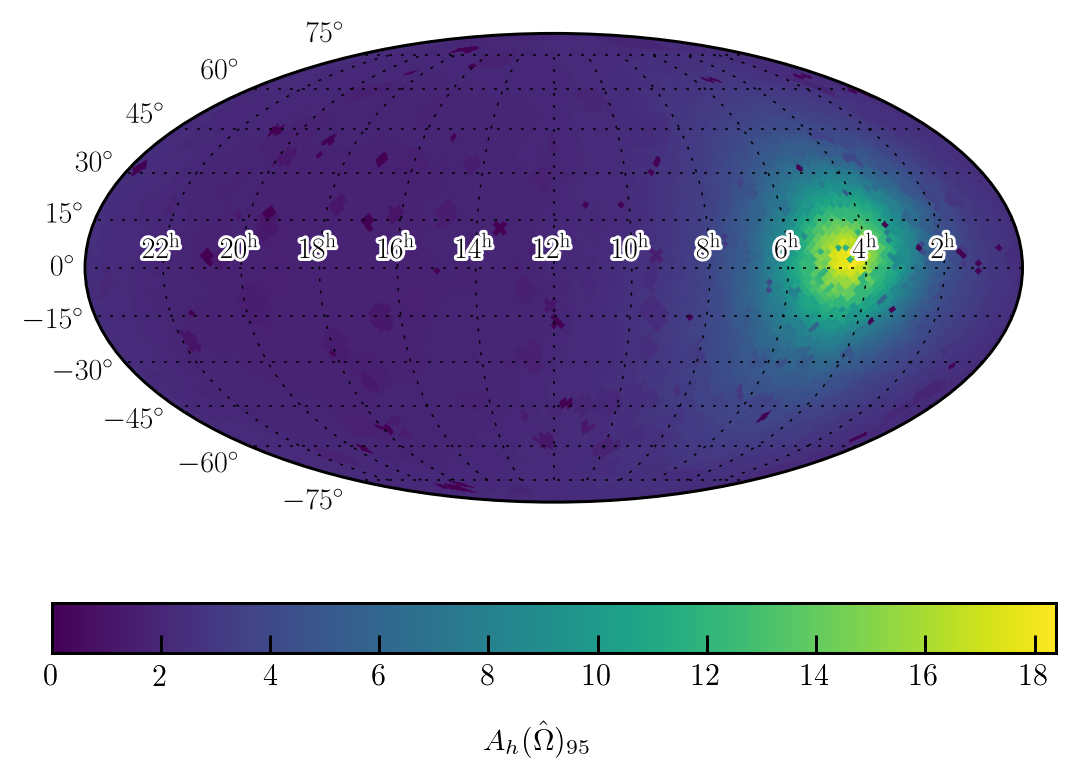

In [42]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(hconf_95upper[flipid],cmap=newcmaps.viridis)

# add pulsars
#ax.plot(positions[:,0], np.pi/2. - positions[:,1], 
#        '*', color='w', markersize=12, mew=1.5, mec='k')

plt.colorbar(orientation='horizontal')
plt.suptitle(r'$A_h(\hat\Omega)_{95}$', y=0.1)

#plt.savefig('nano9yr_gam4p33_qdisk.pdf',bbox_inches='tight',dpi=400)

/Users/staylor/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


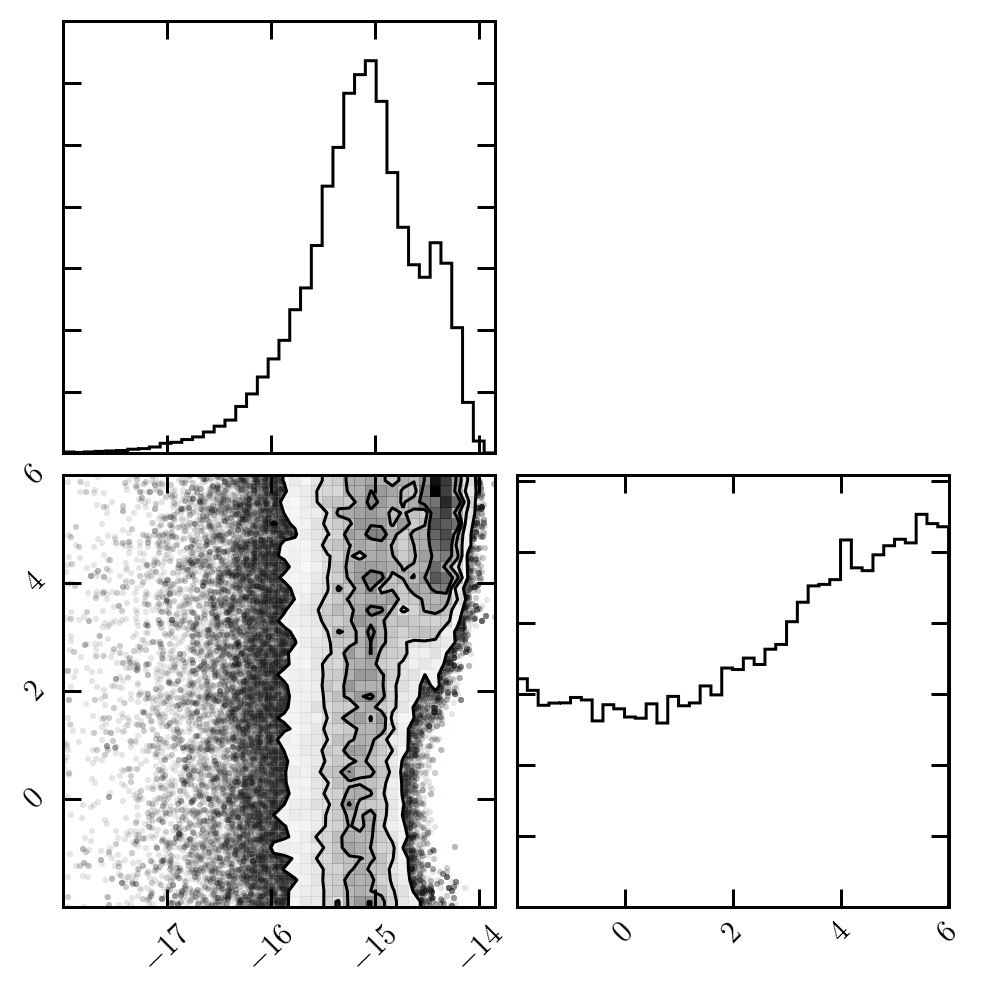

In [102]:
fig = corner.corner(chain_qdisk[:,[36,40]],bins=40)
#fig = corner.corner(newamp,bins=100)

## Model independent recovery

In [61]:
chain_micorr = np.loadtxt('./nano9yr_nemo_chains/freecorr_limit/chain_1.0.txt')

In [62]:
chain_micorr.shape

(133900, 194)

In [63]:
amp_chain = chain_micorr[10000::10,36]

In [64]:
npsr = 18

In [65]:
npairs = int(npsr*(npsr-1)/2)
phi_corr = chain_micorr[1000::10,37:-4].copy()

In [66]:
phi_corr.shape

(13290, 153)

In [67]:
############################################################
# Computing frequency-dependent overlap reduction functions.

Lchol = []
for ii in range(len(phi_corr)): 
    upper_triang = np.zeros((npsr,npsr))
    phi_els = np.array([[0.0]*kk for kk in range(1,npsr)])
    ct=0
    for aa in range(len(phi_els)):
        for bb in range(len(phi_els[aa])):
            phi_els[aa][bb] = phi_corr[ii,ct]
            ct += 1

    upper_triang[0,0] = 1.
    for bb in range(1,upper_triang.shape[1]):
        upper_triang[0,bb] = np.cos(phi_els[bb-1][0])
    for aa in range(1,upper_triang.shape[1]):
        upper_triang[aa,aa] = np.prod( np.sin(phi_els[aa-1]) )
    for aa in range(1,upper_triang.shape[1]):
        for bb in range(aa+1,upper_triang.shape[1]):
            upper_triang[aa,bb] = np.cos(phi_els[bb-1][aa]) * \
            np.prod( np.sin(np.array(phi_els[bb-1])[0:aa]) )  
            
    Lchol.append( upper_triang )
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(phi_corr))
    sys.stdout.flush()

13290 of 13290


In [68]:
Lchol = np.array(Lchol)

In [69]:
Lchol.shape

(13290, 18, 18)

In [70]:
Cmat = []
for ii in range(len(phi_corr)):
    Cmat.append( np.dot(Lchol[ii,:,:].T, Lchol[ii,:,:]) )

In [71]:
Cmat = np.array(Cmat)

In [72]:
Cmat.shape

(13290, 18, 18)

In [119]:
Cmat_offdiag = []
for ii in range(len(phi_corr)):
    Cmat_offdiag.append(Cmat[ii][np.triu_indices(len(positions),k=1)])

In [120]:
Cmat_offdiag = np.array(Cmat_offdiag)

In [121]:
Cmat_offdiag.shape

(13290, 153)

In [122]:
Cmat_offdiag_mean = np.mean(Cmat_offdiag,axis=0)
Cmat_offdiag_std = np.std(Cmat_offdiag,axis=0)

In [129]:
low16 = []
median = []
up84 = []
for ii in range(Cmat_offdiag.shape[1]):
    
    low, up = bu.confinterval(Cmat_offdiag[:,ii],sigma=0.16,onesided=True)
    low16.append(low)
    up84.append(up)
    low, up = bu.confinterval(Cmat_offdiag[:,ii],sigma=0.50,onesided=True)
    median.append(low)
    
    if ii%100 == 0:
        clear_output()
        print '\r', '{0} of {1}'.format(ii+1, Cmat_offdiag.shape[1])
        sys.stdout.flush()

101 of 153


In [100]:
psrvec = np.array([np.sin(positions[:,1])*np.cos(positions[:,0]),
                   np.sin(positions[:,1])*np.sin(positions[:,0]),
                   np.cos(positions[:,1])]).T

In [113]:
angSep = np.zeros((len(positions),len(positions)))
for ii in range(len(positions)):
    for jj in range(len(positions)):
        angSep[ii,jj] = np.arccos(np.dot(psrvec[ii,:],psrvec[jj,:]))
angSep_offdiag = angSep[np.triu_indices(len(positions),k=1)]

In [138]:
plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\usepackage{/Users/staylor/Research/NANOGrav/apjfonts}'],
        'text.usetex':True,
        'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
                                'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': (3.39,2.1)}
plt.rcParams.update(params)

In [147]:
orf_hnd = pixAnis.orfFromMap_fast(positions,np.ones(12288))

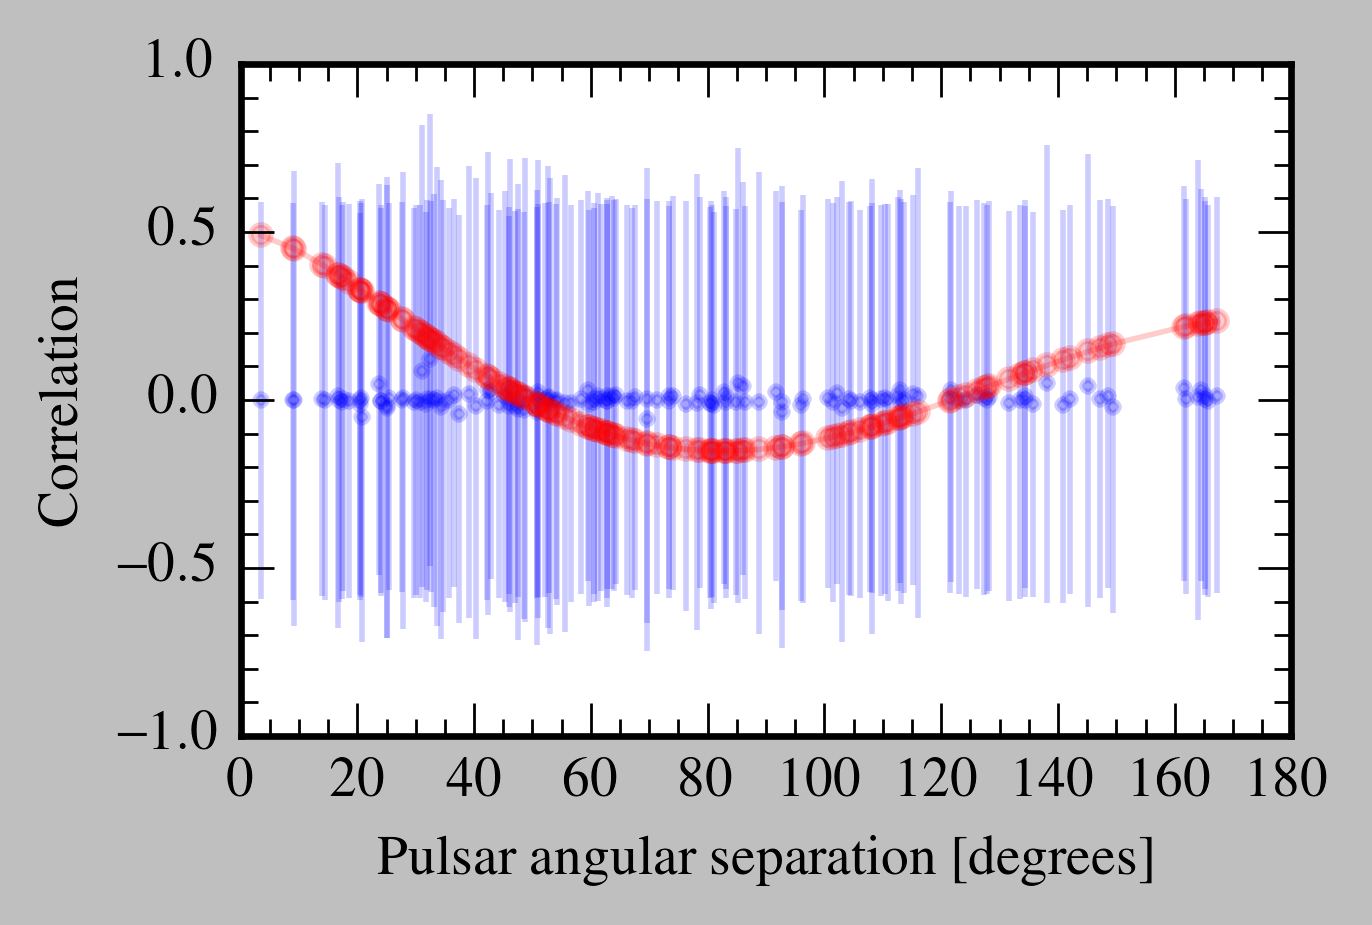

In [162]:
plt.errorbar(angSep_offdiag*180.0/np.pi,median,
             yerr=[np.abs(np.array(low16)-np.array(median)),np.abs(np.array(up84)-np.array(median))],
             linestyle='None',alpha=0.2,fmt='.',capsize=0)

indsort = np.argsort(angSep_offdiag*180.0/np.pi)
plt.plot(angSep_offdiag[indsort]*180.0/np.pi, 
         orf_hnd[np.triu_indices(len(positions),k=1)][indsort],
         marker='.',markersize=7,alpha=0.2,color='red')

plt.ylim(-1.0,1.0)
plt.xlabel('Pulsar angular separation [degrees]')
plt.ylabel('Correlation')
plt.minorticks_on()

plt.savefig('nano9yr_freecorrVSsep.pdf',bbox_inches='tight',dpi=400)

In [117]:
orf_bins_mean = np.zeros(10)
orf_bins_std = np.zeros(10)
for ii in range(10):
    low = np.pi*ii/10.0
    high = np.pi*(ii+1)/10.0
    mask = np.logical_and(angSep_offdiag>=low, angSep_offdiag<=high)
    orf_bins_mean[ii] = np.mean(Cmat_offdiag[:,mask])
    orf_bins_std[ii] = np.std(Cmat_offdiag[:,mask])

<Container object of 3 artists>

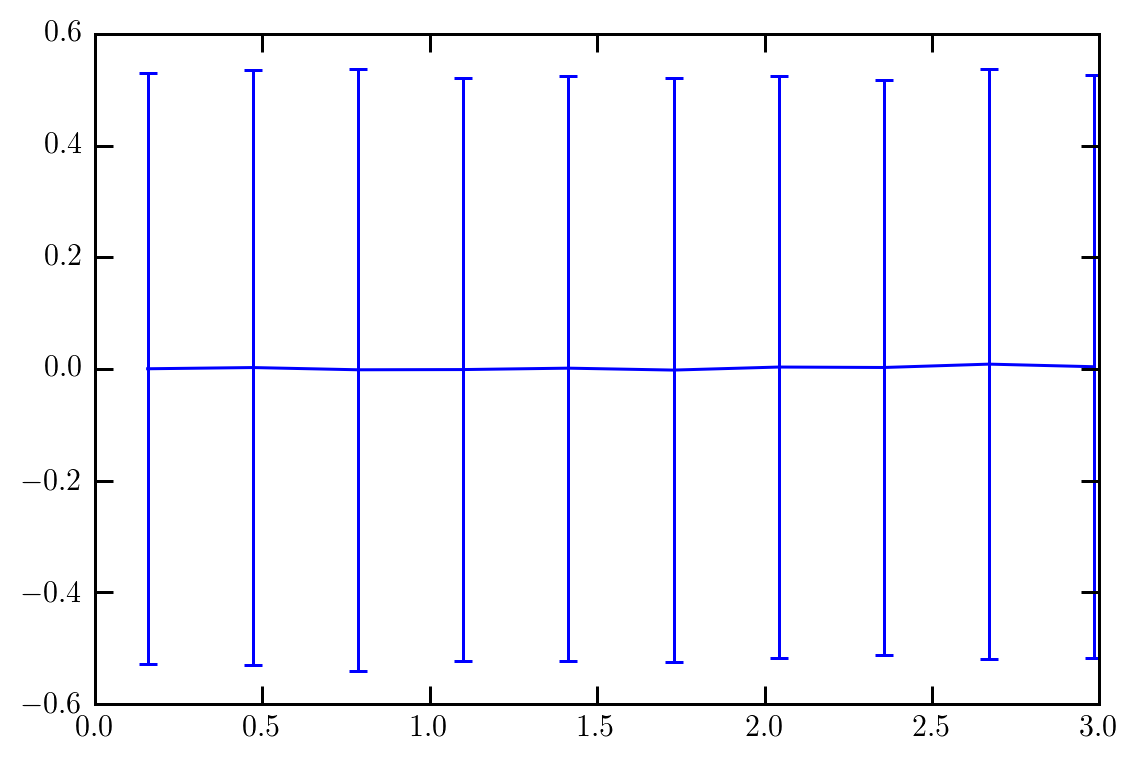

In [118]:
plt.errorbar([np.pi*(ii+0.5)/10.0 for ii in range(10)],orf_bins_mean,yerr=orf_bins_std)

In [ ]:
pphi = positions[:,0]
ptheta = positions[:,1]

# Create the pixels
nside = 32
npixels = hp.nside2npix(nside)
pixels = hp.pix2ang(nside, np.arange(npixels), nest=False)
gwtheta = pixels[0]
gwphi = pixels[1]

# Create the signal response matrix
F_e = pixAnis.signalResponse_fast(ptheta, pphi, gwtheta, gwphi)

In [ ]:
omega = np.array([np.sin(gwtheta)*np.cos(gwphi),
                  np.sin(gwtheta)*np.sin(gwphi),
                  np.cos(gwtheta)])
omegap = np.zeros((3,2*npixels))
omegap[:,0::2] = omega
omegap[:,1::2] = omega

In [ ]:
Fe_tot = np.array(F_e.copy(),dtype=np.complex128) 
for ii in range(npsr):
    psrvec = np.array([np.sin(positions[ii,1])*np.cos(positions[ii,0]),
                       np.sin(positions[ii,1])*np.sin(positions[ii,0]),
                       np.cos(positions[ii,1])])
    fac = (1.0 + np.dot(omegap.T,psrvec))
    print fac.shape
    Fe_tot[ii,:] *= 1.0 # ( 1.0 - np.exp(-1j*1000.0*fac) )

In [ ]:
#Fe_pinv = sl.pinv(F_e)
Fe_pinv = sl.pinv(Fe_tot)

In [ ]:
pwrmap = []
for ii in range(len(Lchol)):
    
    tmp_a = np.dot(Fe_pinv, Lchol[ii,:].T)
    #tmp_b = np.dot(tmp_a,tmp_a.T)
    
    #tmp_a = np.dot(Lchol[ii,:].T, Lchol[ii,:])
    #tmp_a[np.diag_indices(npsr)] *= 0.5
    #tmp_b = np.dot(Fe_pinv, np.dot(tmp_a, Fe_pinv.T))
    
    #tmp_b = np.diag(tmp_b)
    tmp_b = np.sum(tmp_a*tmp_a,axis=1)
    tmp_c = tmp_b[::2] + tmp_b[1::2]
    
    pwrmap.append(tmp_c)
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(Lchol))
    sys.stdout.flush()

In [ ]:
pwrmap = np.array(pwrmap)

In [ ]:
plt.plot(np.abs(pwrmap[0,:]))

In [ ]:
#mean_pwr = np.mean(np.array(pwrmap),axis=0)
strain = [10.0**(2.0*amp_chain) * np.abs(pwrmap[:,ii]) for ii in range(npixels)]
strain = np.array(strain)

In [ ]:
#strain = np.array([Ah[~np.isnan(strain[ii,:])] for Ah in strain])

In [ ]:
hconf_95upper = np.zeros(npixels)
for ii in range(len(hconf_95upper)):
    
    low, up = bu.confinterval(strain[ii,:]**0.5,sigma=0.95,onesided=True)
    hconf_95upper[ii] = up
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1, len(hconf_95upper))
    sys.stdout.flush()

In [ ]:
# Get sky locations of pixels
idx = hp.pix2ang(nside, np.arange(0,npixels))

# Anisotropy parametrized for direction of GW *propagation*.
# So need to flip the sky for *origin*.
theta_h = idx[0]
phi_h = idx[1]

# flip the sky i.e. do a parity transformation
phi_h = np.pi + phi_h
theta_h = np.pi - theta_h

flipid = hp.ang2pix(nside, theta_h, phi_h)

In [ ]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
plot.healpix_heatmap(hconf_95upper[flipid],cmap=newcmaps.viridis)

# add pulsars
ax.plot(positions[:,0], np.pi/2. - positions[:,1], 
        '*', color='w', markersize=12, mew=1.5, mec='k')

plt.colorbar(orientation='horizontal')
plt.suptitle(r'$A_h(\hat\Omega)_{95}$', y=0.1)

#plt.savefig('nano9yr_gam4p33_qdisk.pdf',bbox_inches='tight',dpi=400)

In [ ]:
fig = corner.corner(chain_micorr[:,38],bins=40)

## Point-source anisotropy: produce posterior averaged skymap

In [50]:
pointSrc_chain = np.loadtxt('./nano9yr_nemo_chains/point_limit/chain_1.0.txt')

In [51]:
burn = 10000
pntparams = pointSrc_chain[burn::1,[37,38]]

In [52]:
pntparams[:,0].min(), pntparams[:,0].max()

(0.00076297014010129338, 6.2831663527463961)

In [53]:
amp_chain = pointSrc_chain[burn::1,36]

In [55]:
nside=32

In [56]:
pnt_map = []
for ii in range(len(pntparams)):
    # Grab the stochastic point source parameters
    # NOTE: These are source origin positions!
    gwphi, cosgwtheta = pntparams[ii,:].copy()
    gwtheta = np.arccos(cosgwtheta)

    m = np.zeros(hp.nside2npix(nside))
    index = hp.ang2pix(nside, gwtheta, gwphi)
    m[index] = 4.0*np.pi * 10.0**(2.0*amp_chain[ii])
    #pnt_map.append(hp.sphtfunc.smoothing(m,fwhm=np.pi/180.0,verbose=False))
    pnt_map.append(m)
    
    if ii%1000 == 0:
        clear_output()
        print '\r', gwphi, gwtheta
        print '\r', '{0} of {1}'.format(ii+1, len(pntparams))
        sys.stdout.flush()

1.02928226757 1.66338941514
137001 of 137700


In [57]:
pnt_map = np.array(pnt_map)

In [58]:
pnt_map.shape

(137700, 12288)

In [59]:
#mean_diskmap = np.mean(np.array(disk_map),axis=0)
#pwr = [10.0**(2.0*amp_chain) * pnt_map[:,ii] for ii in range(hp.nside2npix(nside))]
#pwr = np.array(pwr)

In [60]:
hconf_95upper = np.zeros(hp.nside2npix(nside))
for ii in range(len(hconf_95upper)):
    
    #low, up = bu.confinterval(pwr[ii,:]**0.5,sigma=0.95,onesided=True)
    low, up = bu.confinterval(pnt_map[:,ii]**0.5,sigma=0.95,onesided=True)
    if up == 1.0:
        hconf_95upper[ii] = 0.0
    else:
        hconf_95upper[ii] = up
    
    if ii%100 == 0:
        clear_output()
        print '\r', up
        print np.sum(pnt_map[:,ii] != 0.0)
        print '\r', '{0} of {1}'.format(ii+1, len(hconf_95upper))
        sys.stdout.flush()

1.0
0
12201 of 12288


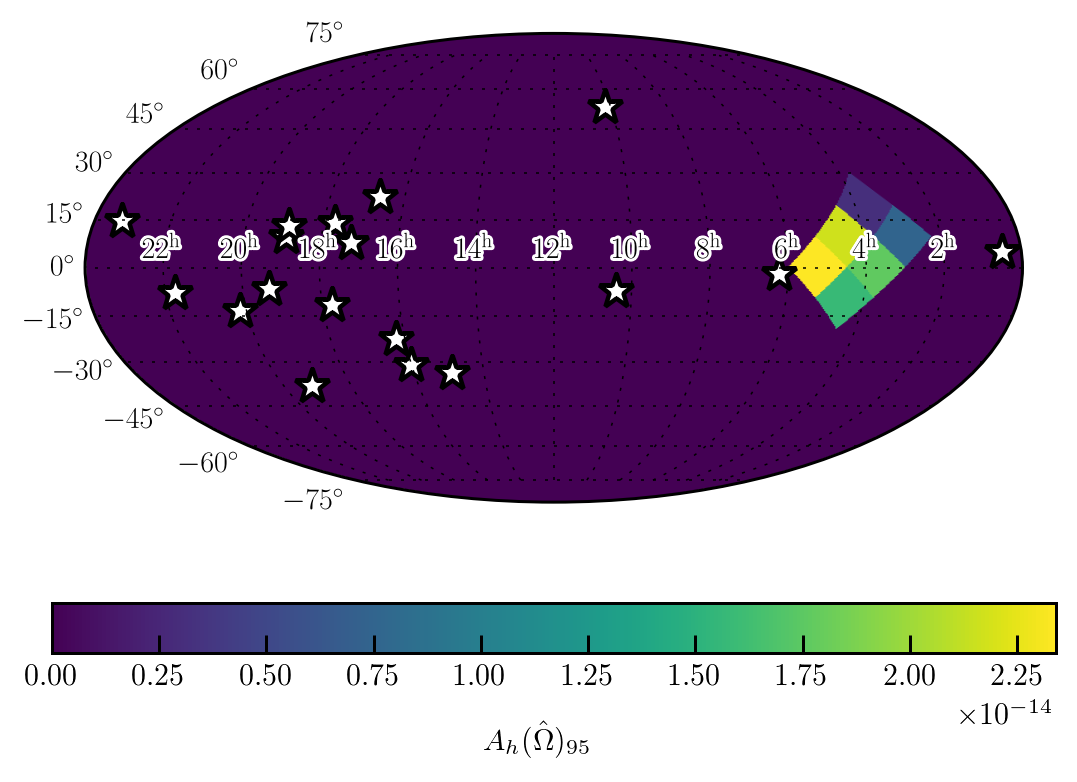

In [101]:
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
plot.outline_text(ax)
#test = hp.sphtfunc.smoothing(hconf_95upper,fwhm=100.0*np.pi/180.0)
#plot.healpix_heatmap(test,cmap=newcmaps.viridis)
plot.healpix_heatmap(hconf_95upper,cmap=newcmaps.viridis)

# add pulsars
ax.plot(positions[:,0], np.pi/2. - positions[:,1], 
        '*', color='w', markersize=12, mew=1.5, mec='k')

plt.colorbar(orientation='horizontal')
plt.suptitle(r'$A_h(\hat\Omega)_{95}$', y=0.1)

#plt.savefig('nano9yr_gam4p33_pntsrc.pdf',bbox_inches='tight',dpi=400)

In [ ]:
bu.plotSkyMap(pointSrc_chain[burn:,37], np.pi/2. - (np.arccos(pointSrc_chain[burn:,38])), nside=32, 
              cmap=newcmaps.viridis, outfile='skymap.pdf')

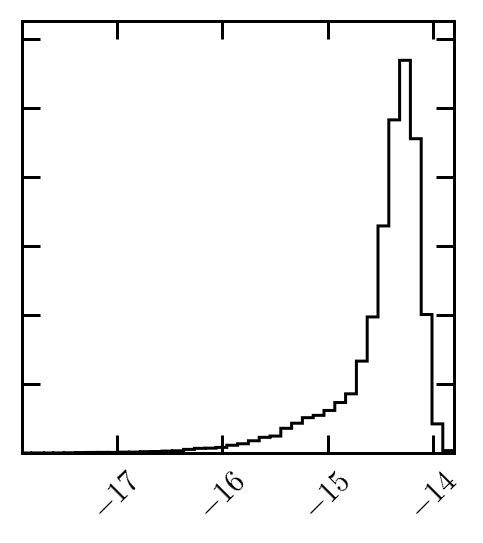

In [103]:
fig = corner.corner(pointSrc_chain[:,[36]],bins=40)
#fig = corner.corner(newamp,bins=100)

### Model-indpendent correlation recovery (Pinheiro & Bates 1996)

In [ ]:
#chain_micorr = np.loadtxt('./chains_ipta_mdc1/pta_gwbloguniform_miCorr_gamVary_redFix_nmodes15/chain_1.0.txt')
chain_micorr = np.loadtxt('./chains_ipta_mdc1/pta_constLike_gwbloguniform_miCorr_gamVary_redFix_nmodes15/chain_1.txt')

In [ ]:
chain_micorr.shape

In [ ]:
orf_coeffs = chain_micorr[100:,2:-4]

In [ ]:
#orf_coeffs = np.random.uniform(-3.0,3.0,(10000,1))
#orf_coeffs = np.random.uniform(0.,np.pi,(990,153))

In [ ]:
npsr=18
npairs = npsr*(npsr-1)/2
#phi_corr = np.pi * np.exp(orf_coeffs) / (1.0 + np.exp(orf_coeffs))
phi_corr = orf_coeffs

############################################################
# Computing frequency-dependent overlap reduction functions.

ORF=[]
for ii in range(orf_coeffs.shape[0]): 
    upper_triang = np.zeros((npsr,npsr))
    phi_els = np.array([[0.0]*kk for kk in range(1,npsr)])
    ct=0
    for aa in range(len(phi_els)):
        for bb in range(len(phi_els[aa])):
            phi_els[aa][bb] = phi_corr[ii,ct]
            ct += 1

    upper_triang[0,0] = 1.
    for bb in range(1,upper_triang.shape[1]):
        upper_triang[0,bb] = np.cos(phi_els[bb-1][0])
    for aa in range(1,upper_triang.shape[1]):
        upper_triang[aa,aa] = np.prod( np.sin(phi_els[aa-1]) )
    for aa in range(1,upper_triang.shape[1]):
        for bb in range(aa+1,upper_triang.shape[1]):
            upper_triang[aa,bb] = np.cos(phi_els[bb-1][aa]) * \
            np.prod( np.sin(np.array(phi_els[bb-1])[0:aa]) )   

    ORF.append(np.dot( upper_triang.T, upper_triang ))

In [ ]:
ORF = np.array(ORF)

In [ ]:
ORF.shape

In [ ]:
n, bins, patches = plt.hist(ORF[:,3,17], 50, normed=1, facecolor='green', alpha=0.75)

In [ ]:
ORF_mean = np.mean(ORF,axis=0)
ORF_std = np.std(ORF,axis=0)

In [ ]:
psrIndices="0,2,4,6,8,10,12,14,16,18"

In [ ]:
psr_pathinfo = np.genfromtxt('./psrList_ipta_mdc1.txt', dtype=str, skip_header=2)

tmp_psr = []
if psrIndices is not None:
    psr_inds = [int(item) for item in psrIndices.split(',')]
    for ii,tmp_name in zip(psr_inds,psr_pathinfo[psr_inds,0]):
        tmp_psr.append(h5.File(psr_pathinfo[ii,1], 'r')[tmp_name])

psr = [NX01_psr.PsrObjFromH5(p) for p in tmp_psr]

# Grab all the pulsar quantities
[p.grab_all_vars() for p in psr]

In [ ]:
angsep = np.zeros((len(psr),len(psr)))
for ii,p in enumerate(psr):
    for jj,q in enumerate(psr):
        if ii == jj:
            angsep[ii,jj] = 0.0
        else:
            phip, thetap = p.psr_locs[0], np.pi/2. - p.psr_locs[1]
            phiq, thetaq = q.psr_locs[0], np.pi/2. - q.psr_locs[1]
            posp = np.array([np.sin(thetap)*np.cos(phip),np.sin(thetap)*np.sin(phip),np.cos(thetap)])
            posq = np.array([np.sin(thetaq)*np.cos(phiq),np.sin(thetaq)*np.sin(phiq),np.cos(thetaq)])
            angsep[ii,jj] = np.arccos(np.dot(posp,posq))

In [ ]:
psr_positions = np.array([np.array([psr[ii].psr_locs[0],
                           np.pi/2. - psr[ii].psr_locs[1]])
                           for ii in range(len(psr))])

In [ ]:
psr_positions

In [ ]:
HnD = 2.0*np.sqrt(np.pi)*pixAnis.CorrBasis(psr_locs=psr_positions, lmax=0, nside=32)[0]

In [ ]:
plt.errorbar(angsep[np.triu_indices(npsr)], ORF_mean[np.triu_indices(npsr)], 
             yerr=ORF_std[np.triu_indices(npsr)], linestyle='None')
plt.plot(angsep[np.triu_indices(npsr)], HnD[np.triu_indices(npsr)],linestyle='None',marker='*')

### Testing Jacobian for uniform sampling in correlation rather than spherical coordinates of Cholesky

In [ ]:
def setup():
    npsr=3
    npairs = int(npsr*(npsr-1)/2)
    theta_corr = np.random.uniform(-5.,5.,npairs) #np.array([-0.608,-0.348,-0.787])
    phi_corr = np.pi * np.exp(theta_corr) / (1.0 + np.exp(theta_corr))
    #phi_corr = np.array([np.pi/4.,np.pi/4.,np.pi/4.])
    #theta_corr = np.log(phi_corr / (np.pi - phi_corr))
    ############################################################
    # Computing frequency-dependent overlap reduction functions.

    ORF=[]
    upper_triang = np.zeros((npsr,npsr))
    phi_els = np.array([[0.0]*kk for kk in range(1,npsr)])
    theta_els = np.array([[0.0]*kk for kk in range(1,npsr)])
    ct=0
    for aa in range(len(phi_els)):
        for bb in range(len(phi_els[aa])):
            phi_els[aa][bb] = phi_corr[ct]
            theta_els[aa][bb] = theta_corr[ct]
            ct += 1

    upper_triang[0,0] = 1.
    for bb in range(1,upper_triang.shape[1]):
        upper_triang[0,bb] = np.cos(phi_els[bb-1][0])
    for aa in range(1,upper_triang.shape[1]):
        upper_triang[aa,aa] = np.prod( np.sin(phi_els[aa-1]) )
    for aa in range(1,upper_triang.shape[1]):
        for bb in range(aa+1,upper_triang.shape[1]):
            upper_triang[aa,bb] = np.cos(phi_els[bb-1][aa]) * \
            np.prod( np.sin(np.array(phi_els[bb-1])[0:aa]) ) 
            
    #upper_triang[:,0] *= 1.0
    #upper_triang[:,1] *= np.sqrt(5.)
    #upper_triang[:,2] *= np.sqrt(14.)
    

    ORF.append(np.dot( upper_triang.T, upper_triang ))
    return npsr, npairs, upper_triang, phi_els, theta_els, ORF

In [ ]:
def doit():
    npsr, npairs, upper_triang, phi_els, theta_els, ORF = setup()
    jacobian = np.zeros((npairs,npairs))
    ct = 0
    for ii in range(len(phi_els)):
        for jj in range(len(phi_els[ii])):

            dummy_utriang = upper_triang[jj:,ii+1].copy()
            dummy_utriang[0] = -np.sin(phi_els[ii][jj]) * dummy_utriang[0] / np.cos(phi_els[ii][jj])
            dummy_utriang[1:] = np.cos(phi_els[ii][jj]) * dummy_utriang[1:] / np.sin(phi_els[ii][jj])

            dummy_utriang = np.append(np.zeros(len(upper_triang[:jj,ii+1])), dummy_utriang)

            deriv = np.zeros_like(upper_triang)
            deriv[:,ii+1] = np.dot(upper_triang.T, dummy_utriang)
            deriv = deriv + deriv.T

            jacobian[:,ct] = deriv[np.triu_indices(npsr,k=1)] * phi_els[ii][jj] / (1.0 + np.exp(theta_els[ii][jj]))
            ct += 1
    return ORF, jacobian, np.linalg.slogdet(jacobian)

In [ ]:
%timeit doit()

In [ ]:
doit()

In [ ]:
jacobian[np.triu_indices(3,k=1)]

In [ ]:
test = np.arange(0,16).reshape((4,4))
print test, test[np.triu_indices(4,k=1)]